In [1]:
import numpy as np
from scipy.constants import e,epsilon_0,pi,hbar, m_e, physical_constants
from matplotlib import pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter

# Inputs

In [8]:
'Xray diameter (m)'
xray_spotwidth = 25e-6

'Pulse energy (Joule)'
Ep = 30e-6#1.3e-6

'Photon energy (eV)'
Egamma_eV=1880

'Diameter of the nanoparticle (m)'
d = 500e-9

'Mean free path of electrons (m)'
dr = 3e-9

'Skin depth of photons (m)'
skin_depth = 1420e-9

'Electrons emitted per absorbed photon'
e_per_phot = 2

'Number of slices the sphere should be cut into in each direction'
Nslices = 51 # preferably odd number

# Code

### Compute necessary values from inputs

In [9]:
'Photon energy (J)'
Egamma = Egamma_eV*e

'Spot size of the Xray (square meter)'
Area_xraySpot = pi*(xray_spotwidth/2)**2

'Size of one cell in the array (m)'
cellSize = d/Nslices

'Beam energy at the cell (J)'
Ecell = Ep/Area_xraySpot*cellSize**2

'Number of photons per cell'
NphotonsCell = Ecell/Egamma

### The Loop

In [10]:
### Generate sphere as 3D numpy array

'Radius of sphere'
radius = int((Nslices-1)/2)

'Cubic array of zeros'
sphere = np.zeros((Nslices,Nslices, Nslices))

'Coordinates of the center of the sphere in the array'
x0, y0, z0 = int(np.floor(sphere.shape[0]/2)), \
        int(np.floor(sphere.shape[1]/2)), int(np.floor(sphere.shape[2]/2))

'List of ring indices'
ring_indices = list()

for x in range(x0-radius, x0+radius+1):
    for y in range(y0-radius, y0+radius+1):
        for z in range(z0-radius, z0+radius+1):
            
            'Current radial distance'
            radial_squared = (x0-x)**2 + (y0-y)**2 + (z0-z)**2
            
            '''deb: measures how far a coordinate in A is far from the center. 
                    deb>=0: inside the sphere.
                    deb<0: outside the sphere.'''
            deb = radius**2 - radial_squared
            
            'If we are in the sphere'
            if (deb)>=0: 
                
                
                ### Compute number of photons in each cell
                
                'Compute the number of cells previously seen by the beam'
                prevCells = 0
                for prevx in range(x):
                    if sphere[prevx,y,z] != 0:
                        prevCells += 1
                        
                'How far into the nanoparticle we find ourselves along the x-axis'
                xdepth = prevCells*cellSize
                
                'Part of the beam incoming after being transmitted earlier'
                incoming_light = np.exp(-xdepth/skin_depth)
                
                'Absorption coefficient in specific cell'
                absorption = 1 - np.exp(-cellSize/skin_depth)
                
                'Apply absorption to number of photons'
                newNphotonsCell = NphotonsCell*incoming_light*absorption
                
                
                ### Compute number of electrons in each cell
                
                'Appy electrons per photon coefficient to number of photons per cell'
                NelectronsCell = newNphotonsCell * e_per_phot
                
                
                ### Compute contribution to the surface density
                
                'How far away from the surface we are'
                depth = ( radius - np.sqrt(radial_squared) ) * cellSize

                'Contribution coefficient to the surface'
                contribution = np.exp(-depth/dr)

                'Apply contribution coefficient to number of electrons'
                NelectronsContributingCell = NelectronsCell*contribution
                
                'Fill sphere with number of electrons contributing per cell'
                sphere[x,y,z] = NelectronsContributingCell
                
                
                ### Recover indices of surface sphere or ring slicing sphere through the middle of y axis
                if y==y0 and radius - np.sqrt(radial_squared) < 1:
                    
                    'Current index of cell'
                    index = (x,y,z)

                    'Add index to list of the ring'
                    ring_indices.append(index)
                    
                
                

#print(sphere)
#print(ring_indices)


### Compute ion energy

'Ion energies squared array'
energies = np.zeros((Nslices,Nslices))

'Number of cells on the surface'
NcellsSurface = 0

'Loop through ring'
for (i,j,k) in ring_indices:
    
    energy = 0
    
    NcellsSurface += 1
    
    'Loop through circle'
    for x in range(Nslices):
        for y in range(Nslices):
            for z in range(Nslices):

                'Distance between index and current cell'
                r = ( np.sqrt( (x-i)**2 + (y-j)**2 + (z-k)**2 ) + 1 ) * cellSize 
                
                'Charge'
                Q = sphere[x,y,z] * e

                'Electric field (eV)'
                E = Q/(4*pi*epsilon_0*r)

                energy += E
    
    energies[i,k] = energy

#print(energies)

# Results

In [11]:
### Printing inputs

print('Inputs:')
print('-------')
print('   X-ray diameter (microns):               %.0f'%(xray_spotwidth/1e-6))
# print('   Area of x-ray spot (square microns):    %.2f'%(Area_xraySpot))
print('   Pulse Energy (micro Joule):             %.2f'%(Ep/1e-6))
print('   Photon energy (eV):                     %.0f'%(Egamma_eV))
print('   Particle diameter (nanometer):          %.0f'%(d/1e-9))
print('   Absorbing shell thickness (nanometer):  %.0f'%(dr/1e-9))
print('   Skin depth of SiO2 (nm):                %.0f'%(skin_depth*1e9))
print('   Number of cells in each direction       %.0f'%(Nslices))


##############################################################


### Printing results

print('')
print('Results:')
print('--------')

'Total number of electrons contributing is the sum of the electrons contributing in the cells'
tot_electrons = sum(sum(sum(sphere)))

print('   Number of electrons contributing:       %.0f'%(tot_electrons))

'Average energy on the ring'
avg_energy = sum(sum(energies))/NcellsSurface

print('   Average ion energy on the surface (eV):  %.0f'%(avg_energy))

Inputs:
-------
   X-ray diameter (microns):               25
   Pulse Energy (micro Joule):             30.00
   Photon energy (eV):                     1880
   Particle diameter (nanometer):          500
   Absorbing shell thickness (nanometer):  3
   Skin depth of SiO2 (nm):                1420
   Number of cells in each direction       51

Results:
--------
   Number of electrons contributing:       540364
   Average ion energy on the surface (eV):  2942


### Plot ion energy as a function of generated electrons

In [6]:
'List of number of electrons leaving nanoparticle'
n_electrons_list = np.geomspace(10, 12000, num=100)

### Generate sphere as 3D numpy array

'Radius of sphere'
radius = int((Nslices-1)/2)

'Cubic array of zeros'
sphere = np.zeros((Nslices,Nslices, Nslices))

'Coordinates of the center of the sphere in the array'
x0, y0, z0 = int(np.floor(sphere.shape[0]/2)), \
        int(np.floor(sphere.shape[1]/2)), int(np.floor(sphere.shape[2]/2))

'List of ring indices'
ring_indices = list()

for x in range(x0-radius, x0+radius+1):
    for y in range(y0-radius, y0+radius+1):
        for z in range(z0-radius, z0+radius+1):
            
            'Current radial distance'
            radial_squared = (x0-x)**2 + (y0-y)**2 + (z0-z)**2
            
            '''deb: measures how far a coordinate in A is far from the center. 
                    deb>=0: inside the sphere.
                    deb<0: outside the sphere.'''
            deb = radius**2 - radial_squared
            
            'If we are in the sphere'
            if (deb)>=0: 
                
                
                ### Compute number of photons in each cell
                
                'Compute the number of cells previously seen by the beam'
                prevCells = 0
                for prevx in range(x):
                    if sphere[prevx,y,z] != 0:
                        prevCells += 1
                        
                'How far into the nanoparticle we find ourselves along the x-axis'
                xdepth = prevCells*cellSize
                
                'Part of the beam incoming after being transmitted earlier'
                incoming_light = np.exp(-xdepth/skin_depth)
                
                'Absorption coefficient in specific cell'
                absorption = 1 - np.exp(-cellSize/skin_depth)
                
                'Apply absorption to number of photons'
                newNphotonsCell = NphotonsCell*incoming_light*absorption
                
                
                ### Compute number of electrons in each cell
                
                'Appy electrons per photon coefficient to number of photons per cell'
                NelectronsCell = newNphotonsCell * e_per_phot
                
                
                ### Compute contribution to the surface density
                
                'How far away from the surface we are'
                depth = ( radius - np.sqrt(radial_squared) ) * cellSize

                'Contribution coefficient to the surface'
                contribution = np.exp(-depth/dr)

                'Apply contribution coefficient to number of electrons'
                NelectronsContributingCell = NelectronsCell*contribution
                
                'Fill sphere with number of electrons contributing per cell'
                sphere[x,y,z] = NelectronsContributingCell
                
                
                ### Recover indices of surface sphere or ring slicing sphere through the middle of y axis
                if y==y0 and radius - np.sqrt(radial_squared) < 1:
                    
                    'Current index of cell'
                    index = (x,y,z)

                    'Add index to list of the ring'
                    ring_indices.append(index)
                    
                
                

#print(sphere)
#print(ring_indices)


### Compute ion energy

'Ion energies squared array'
energies = np.zeros((Nslices,Nslices))

'Number of cells on the surface'
NcellsSurface = 0

'Loop through ring'
for (i,j,k) in ring_indices:
    
    energy = 0
    
    NcellsSurface += 1
    
    'Loop through circle'
    for x in range(Nslices):
        for y in range(Nslices):
            for z in range(Nslices):

                'Distance between index and current cell'
                r = ( np.sqrt( (x-i)**2 + (y-j)**2 + (z-k)**2 ) + 1 ) * cellSize 
                
                'Charge'
                Q = sphere[x,y,z] * e

                'Electric field (eV)'
                E = Q/(4*pi*epsilon_0*r)

                energy += E
    
    energies[i,k] = energy

#print(energies)

### Plot 3D heatmap of electrons in nanoparticle

In [5]:
# 3D Heatmap in Python using matplotlib

# to make plot interactive 
%matplotlib osx
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from pylab import cm
  
# creating figures
fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(111, projection='3d')

index = list()
electrons = list()
for i, el in np.ndenumerate(sphere):
    if el != 0:
        index.append(i)
        electrons.append(el)

dt=np.dtype('int,int,int')
indexarray = np.array(index,dtype=dt)
x,y,z = indexarray['f0']*cellSize-d/2,indexarray['f1']*cellSize-d/2,indexarray['f2']*cellSize-d/2

electrons_zero_origin = electrons-min(electrons)
electrons_norm = electrons_zero_origin/max(electrons_zero_origin)

# setting color bar
color_map = cm.ScalarMappable(cmap=cm.viridis)
color_map.set_array(electrons)
colors = cm.viridis(electrons_norm)

# creating the heatmap
img = ax.scatter(x*1e9, y*1e9, z*1e9, c=colors, marker='s')
cb = plt.colorbar(color_map)

cb.set_label('Number of electrons generated per cell', fontsize = 15)
cb.ax.tick_params(labelsize = 15)
  
# adding title and labels
ax.set_title("Electrons generated in the nanoparticle")
ax.set_xlabel('X-axis (nm)', fontsize = 15)
ax.set_ylabel('Y-axis (nm)', fontsize = 15)
ax.set_zlabel('Z-axis (nm)', fontsize = 15)
ax.tick_params(axis="both", labelsize = 15)

# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(True)
  
# displaying plot
plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

### Plot 2D heatmap of electrons in cut of the nanoparticle

#### Cartesian

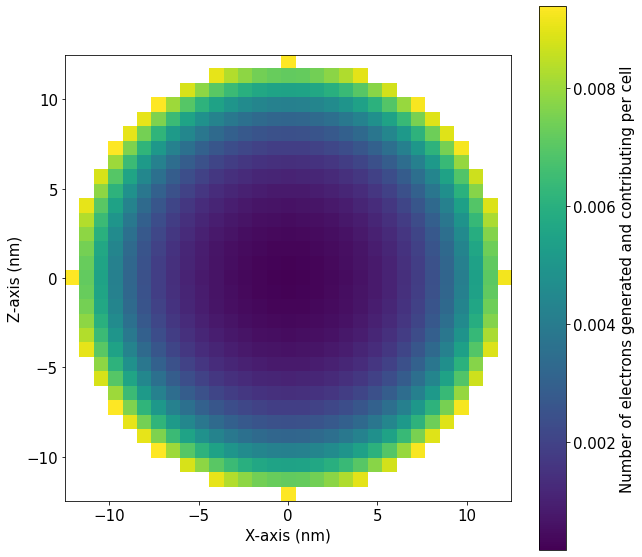

In [7]:
%matplotlib inline

sphere2d = sphere[:,y0,:]

sphere2d[sphere2d == 0] = np.nan

fig = plt.figure(figsize=(10, 10))

plt.imshow(sphere2d.T, cmap='viridis', interpolation='nearest', extent=[-d*1e9/2,d*1e9/2,-d*1e9/2,d*1e9/2], origin='lower')
 
cb = plt.colorbar()
cb.set_label('Number of electrons generated and contributing per cell', fontsize = 15)
cb.ax.tick_params(labelsize = 15)
 
#plt.title("Electrons generated and contributing in cut of the nanoparticle")
plt.xlabel('X-axis (nm)', fontsize = 15)
plt.ylabel('Z-axis (nm)', fontsize = 15)
plt.tick_params(axis="both", labelsize = 15)
#plt.axes[1].tick_params(axis="y", labelsize=21)
#plt.tick_params(axis="y", labelsize = 15)

plt.show()

#### Polar

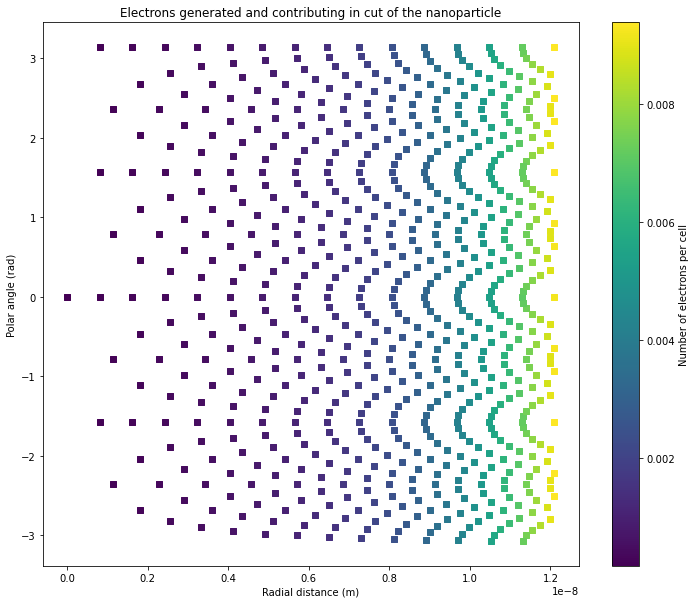

In [8]:
index = list()
electrons = list()
for i, el in np.ndenumerate(sphere2d):
    if el != 0:
        index.append(i)
        electrons.append(el)
        
dt=np.dtype('int,int')
indexarray = np.array(index,dtype=dt)
x,z = indexarray['f0']-(Nslices-1)/2,indexarray['f1']-(Nslices-1)/2
# x,z = indexarray['f0']*cellSize-(d-cellSize)/2,indexarray['f1']*cellSize-(d-cellSize)/2

r = np.sqrt(x**2+z**2)*cellSize
theta = np.arctan2(z,x)

# data = np.array([x,z,r,theta])
# column_labels = ['x','z','r','theta']
# row_labels = range(len(x))

# df = pd.DataFrame(data, columns=row_labels, index=column_labels)

%matplotlib inline

fig = plt.figure(figsize=(12, 10))

plt.scatter(r, theta, c=electrons, marker='s')

# setting color bar
cb = plt.colorbar()
cb.set_label('Number of electrons per cell')
 
plt.title("Electrons generated and contributing in cut of the nanoparticle")
plt.xlabel('Radial distance (m)')
plt.ylabel('Polar angle (rad)')

plt.show()

### Plot 2D heatmap of ion energies in cut of the nanoparticle

#### Cartesian

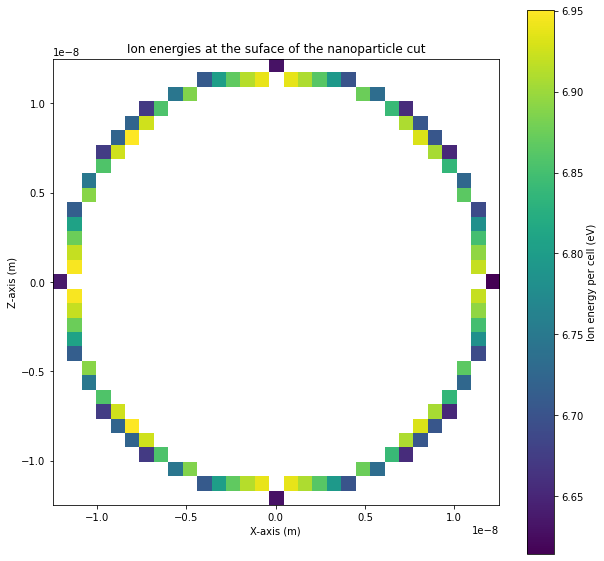

In [9]:
%matplotlib inline

energies[energies == 0] = np.nan

fig = plt.figure(figsize=(10, 10))

plt.imshow(energies.T, cmap='viridis', interpolation='nearest', extent=[-d/2,d/2,-d/2,d/2], origin='lower')
 
cb = plt.colorbar()
cb.set_label('Ion energy per cell (eV)')
 
plt.title("Ion energies at the suface of the nanoparticle cut")
plt.xlabel('X-axis (m)')
plt.ylabel('Z-axis (m)')

plt.show()

### Plot 2D scatter plot of ion energies in cut of the nanoparticle

#### Polar

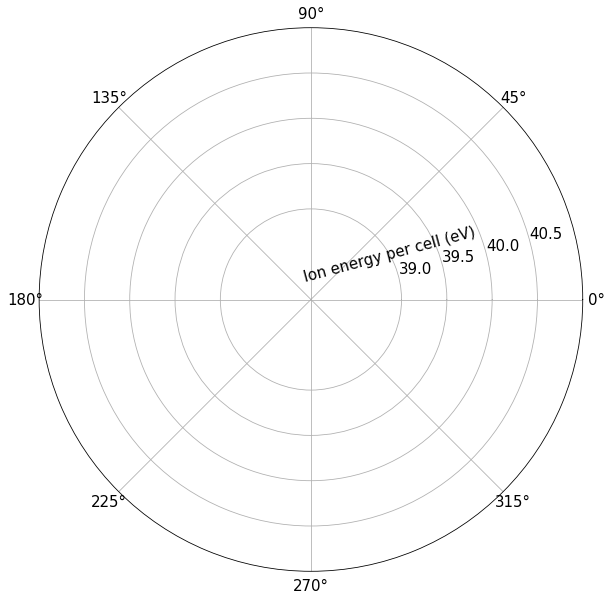

In [10]:
index = list()
electrons = list()
for i, el in np.ndenumerate(energies):
    if el != 0 and ~np.isnan(el):
        index.append(i)
        electrons.append(el)
        
gauss_electrons = gaussian_filter(electrons,sigma=10)
        
dt=np.dtype('int,int')
indexarray = np.array(index,dtype=dt)
x,z = indexarray['f0']-(Nslices-1)/2,indexarray['f1']-(Nslices-1)/2

r = np.sqrt(x**2+z**2)*cellSize
theta = np.arctan2(z,x)

%matplotlib inline

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

ax.scatter(theta, gauss_electrons)
ax.set_rmin(38)
ax.set_rmax(41)
ax.set_rticks([39, 39.5, 40,40.5])  # Less radial ticks
ax.set_rlabel_position(15)  # Move radial labels away from plotted line
ax.grid(True)
label_position=ax.get_rlabel_position()
ax.text(np.radians(30),39,'Ion energy per cell (eV)',
        rotation=label_position,ha='center',va='center', fontsize = 15)
ax.tick_params(axis="both", labelsize = 15)

plt.show()

In [ ]:
def print_in_right_unit(value):
    units = [
        (1e-3, 'meV'),
        (1, 'eV'),
        (1e3, 'keV'),
        (1e6, 'MeV'),
        (1e9, 'GeV'),
        (1e12, 'TeV')
    ]
    
    for conversion_factor, unit in units:
        if conversion_factor < value < conversion_factor*1000:
            print(f'{value/conversion_factor} {unit}')
            return